In [1]:
from __future__ import print_function
import os

import pandas as pd
import numpy as np
import matplotlib

# Ingestión de datos

In [2]:
data_path = ['data']
file_name = 'Vuelos.csv'
filepath = os.sep.join(data_path + [file_name])

dataset = pd.read_csv(filepath, low_memory=False)

Se presentan las primeras 5 observaciones y las dimensiones de la tabla de observaciones. Notamos que la cantidad de observaciones es alta comparado con la cantidad de features, lo cúal es muy positivo cuando se aplican modelos estadísticos.

In [3]:
display(dataset.shape)
display(dataset.head(5))

(480085, 38)

,Unnamed: 0,MONTH,DAY_OF_MONTH,FL_DATE,UNIQUE_CARRIER,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,ORIGIN_STATE_NM,ORIGIN_WAC,...,ACTUAL_ELAPSED_TIME,FLIGHTS,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 36
0,0,8,31,2017-08-31,F9,LGA,"New York, NY",NY,New York,22,...,175.0,1.0,762.0,4,NaN,NaN,NaN,NaN,NaN,NaN
1,1,8,2,2017-08-02,WN,STL,"St. Louis, MO",MO,Missouri,64,...,NaN,1.0,888.0,4,NaN,NaN,NaN,NaN,NaN,NaN
2,2,8,2,2017-08-02,WN,STL,"St. Louis, MO",MO,Missouri,64,...,138.0,1.0,888.0,4,NaN,NaN,NaN,NaN,NaN,NaN
3,3,8,2,2017-08-02,WN,STL,"St. Louis, MO",MO,Missouri,64,...,166.0,1.0,888.0,4,0.0,39.0,26.0,0.0,44.0,NaN
4,4,8,2,2017-08-02,WN,TPA,"Tampa, FL",FL,Florida,33,...,NaN,1.0,1130.0,5,NaN,NaN,NaN,NaN,NaN,NaN


En lo anterior se observa la presencia de dos features sin nombre, "Unnamed: 0" y "Unnamed: 36". El caso de la primera variable parece cumplir una función de orden, por lo que es inecesaria pues ya contamos con los indices del dataframe, por lo que si confirmamos esto entonces esta columna podría eliminarse. El caso de la segunda variable lo analizaremos más adelante cuando contemos con más información.

In [4]:
print(pd.DataFrame(dataset['Unnamed: 0']).equals(pd.DataFrame(np.linspace(0,480084,480084,dtype=int)))) #Deberia dar True
print('\n')
dataset.info()

False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480085 entries, 0 to 480084
Data columns (total 38 columns):
Unnamed: 0             480085 non-null int64
MONTH                  480085 non-null int64
DAY_OF_MONTH           480085 non-null int64
FL_DATE                480085 non-null object
UNIQUE_CARRIER         480085 non-null object
ORIGIN                 480085 non-null object
ORIGIN_CITY_NAME       480085 non-null object
ORIGIN_STATE_ABR       480085 non-null object
ORIGIN_STATE_NM        480085 non-null object
ORIGIN_WAC             480085 non-null int64
DEST                   480085 non-null object
DEST_CITY_NAME         480085 non-null object
DEST_STATE_ABR         480085 non-null object
DEST_STATE_NM          480085 non-null object
DEST_WAC               480085 non-null int64
DEP_TIME               468246 non-null float64
DEP_DELAY              468236 non-null float64
DEP_DELAY_NEW          468236 non-null float64
DEP_DEL15              468236 non-null float64
DEP_DELA

Se observa que "Unnamed: 0" de hecho si cumplía una función de enumeración por lo se procede a eliminar, además "Unnamed: 36" posee 0 valores no nulos, por lo que se concluye que es imposible conseguir información reelevante de esta columna y se eliminará.
Un patrón importante es que las variables relacionadas con motivo de atraso son aquellas que presentan mayor cantidad de valores nulos, más aún, todas tienen exactamente la misma cantidad de valores nulos, esto nos lleva a considerar la posibilidad que un valor nulo signifique enrealidad que no hubo ningún atraso por lo que no se registra la causa, esto lo confirmamos a continuación.

In [5]:
#Eliminamos las columnas que no aportan información
dataset.drop(['Unnamed: 36','Unnamed: 0'], axis=1, inplace=True)

#Agregar función que confirme en su gran mayoría cuando delay es positivo entonces los valores de los motivos son no-nulos
mascara = dataset['ARR_DELAY']>0 
mascara2 = dataset['DEP_DELAY']>0
mascara3 = mascara | mascara2
dataset[mascara].info()
del mascara,mascara2,mascara3

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169840 entries, 0 to 480084
Data columns (total 36 columns):
MONTH                  169840 non-null int64
DAY_OF_MONTH           169840 non-null int64
FL_DATE                169840 non-null object
UNIQUE_CARRIER         169840 non-null object
ORIGIN                 169840 non-null object
ORIGIN_CITY_NAME       169840 non-null object
ORIGIN_STATE_ABR       169840 non-null object
ORIGIN_STATE_NM        169840 non-null object
ORIGIN_WAC             169840 non-null int64
DEST                   169840 non-null object
DEST_CITY_NAME         169840 non-null object
DEST_STATE_ABR         169840 non-null object
DEST_STATE_NM          169840 non-null object
DEST_WAC               169840 non-null int64
DEP_TIME               169840 non-null float64
DEP_DELAY              169840 non-null float64
DEP_DELAY_NEW          169840 non-null float64
DEP_DEL15              169840 non-null float64
DEP_DELAY_GROUP        169840 non-null float64
DEP_TIME_BLK  

Observe que cuando consideramos solamente el subconjunto de los datos en los que hubo un atraso, la diferencia entre el total de los datos y la cantidad de valores no nulos de las variables con motivos de atraso disminuye considerablemente, aquellos datos que siguen teniendo valores nulos probablemente es porque no se registró la causa del retraso.

Ahora vamos a analizar las observaciones que corresponden a atrasos. Observe que el feature "ARR DELAY" considera también las llegadas antes del tiempo programado y los diferencia por medio de números negativos. Estos números negativos dificultan el análisis de los atrasos de los aviones (por ejemplo cuando se calcula un promedio), debido a esto surge la necesidad de crear una columna similar a "DEP DELAY NEW" que da como valor 0 cuando el avión llega antes de tiempo, de esta manera solo se enfoca en las llegadas tardías. Llamaremos a esta variable "ARR DELAY NEW" para ser consistente en el nombre de las variables.

In [6]:
temp = dataset['ARR_DELAY']
temp[temp < 0] = 0 
dataset['ARR_DELAY_NEW'] = temp
del temp

C:\Users\Pollo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Para comenzar el analisis primeramente debemos hacer algo con los valores nulos. Según ............  la probabilidad de que un vuelo se atrase no es muy alta, además dada la gran cantidad de valores nulos y los puntos expuesto inicio del documento, asumiremos que un valor nulo no es más que una forma de registrar que no hubo atraso. Por lo que sustituiremos los NaN por 0. A continuación una breve descripción de los features más reelevantes conrespecto a atrasos.

In [7]:
desc = dataset[dataset.columns[([0,15,16,17,18,21,22,23,24,25,26,27,29,30,31,32,33,34,35,36])]]
print(desc.describe())

               MONTH      DEP_DELAY  DEP_DELAY_NEW      DEP_DEL15  \
count  480085.000000  468236.000000  468236.000000  468236.000000   
mean        6.522522      15.403781      18.434883       0.228346   
std         3.404854      54.283760      53.125508       0.419767   
min         1.000000     -84.000000       0.000000       0.000000   
25%         4.000000      -5.000000       0.000000       0.000000   
50%         7.000000      -2.000000       0.000000       0.000000   
75%         9.000000      11.000000      11.000000       0.000000   
max        12.000000    1685.000000    1685.000000       1.000000   

       DEP_DELAY_GROUP      ARR_DELAY      ARR_DEL15  ARR_DELAY_GROUP  \
count    468236.000000  466352.000000  466352.000000    466352.000000   
mean          0.354919      18.213442       0.229505        -0.008286   
std           2.649006      52.307365       0.420515         2.832210   
min          -2.000000       0.000000       0.000000        -2.000000   
25%          

De la tabla anterior podemos concluir: #falta corregir error que hace que no se calculen bien.
- El bloque de meses con mayor cantidad de atrasos es julio, agosto y setiembre.
- Más de un 50% de las salidas ocurren más temprano de lo programado, sin embargo en promedio los atrasos continúan siendo mayores a las saldas temprano.
- 

In [8]:
#Tabla de freciencia de ciudades de las que provienen los vuelos a NY.
mascara = dataset['DEST_STATE_ABR']=='NY'
temp = dataset[mascara] #Filtro que permite centrarnos unicamente en los vuelos que se dirigen a NY
a = pd.value_counts(temp['ORIGIN_STATE_NM'])
b = 100 * temp['ORIGIN_STATE_NM'].value_counts() / len(temp['ORIGIN_STATE_NM'])
c = pd.concat([a, b], axis=1)
c.columns = ['Frecuencia' , 'Frecuencia Relativa (en %)']
print(c.head())
del a,b,c
temp['ORIGIN_STATE_NM'].value_counts().plot(kind='bar',title='Origen de los vuelos que llegan a NY')

                Frecuencia  Frecuencia Relativa (en %)
Florida              56632                   23.082504
California           25346                   10.330717
Illinois             21082                    8.592763
Georgia              18920                    7.711558
North Carolina       13525                    5.512623


In [9]:
# Tabla de contingencia vuelos dirigidos a NY según Origen / Mes
pd.crosstab(index=temp['ORIGIN_STATE_NM'], columns=temp['MONTH'], margins=True)

MONTH,1,2,3,4,5,6,7,8,9,10,11,12,All
ORIGIN_STATE_NM,,,,,,,,,,,,,
Alabama,39,41,54,26,42,44,37,41,30,39,10,33,436
Arizona,251,244,303,292,271,262,266,260,225,247,230,249,3100
Arkansas,20,22,27,25,25,26,20,27,23,27,6,17,265
California,2081,1904,2228,2120,2139,2121,2201,2256,2032,2145,2034,2085,25346
Colorado,429,393,473,413,471,507,538,541,469,484,406,445,5569
Florida,4903,4532,5576,5279,4711,4464,4540,4513,3970,4296,4609,5239,56632
Georgia,1496,1370,1623,1579,1656,1605,1634,1665,1550,1634,1561,1547,18920
Hawaii,52,45,49,30,31,30,31,31,30,29,27,40,425
Illinois,1435,1349,1595,1477,1767,1961,2050,2121,1853,2000,1757,1717,21082


In [10]:
# Tabla de contingencia Origen / Ciudad de New York (Para analizar cuales son las ciudades que mas son visitadas en NY)
pd.crosstab(index = temp['ORIGIN_STATE_NM'], columns = temp['DEST_CITY_NAME'], margins=True)

DEST_CITY_NAME,"Albany, NY","Binghamton, NY","Buffalo, NY","Elmira/Corning, NY","Islip, NY","Ithaca/Cortland, NY","New York, NY","Newburgh/Poughkeepsie, NY","Niagara Falls, NY","Plattsburgh, NY","Rochester, NY","Syracuse, NY","White Plains, NY",All
ORIGIN_STATE_NM,,,,,,,,,,,,,,
Alabama,0,0,0,0,0,0,436,0,0,0,0,0,0,436
Arizona,0,0,365,0,0,0,2735,0,0,0,0,0,0,3100
Arkansas,0,0,0,0,0,0,265,0,0,0,0,0,0,265
California,0,0,336,0,0,0,25010,0,0,0,0,0,0,25346
Colorado,239,0,0,0,0,0,5330,0,0,0,0,0,0,5569
Florida,2213,0,3176,0,3536,0,40922,730,405,403,755,533,3959,56632
Georgia,1031,0,1664,11,0,0,12163,0,0,0,1057,1051,1943,18920
Hawaii,0,0,0,0,0,0,425,0,0,0,0,0,0,425
Illinois,1712,0,2551,0,0,0,13696,0,0,0,1063,1299,761,21082


In [11]:
#Proporción de viajes a cada una de las ciudades del estado NY 
temp2 = 100 * temp['DEST_CITY_NAME'].value_counts() / len(temp['DEST_CITY_NAME'])
temp2 = temp2.to_frame()
temp2.columns = ['Frecuencia relativa']
print(temp2)
del temp2, mascara

                           Frecuencia relativa
New York, NY                         76.525804
Buffalo, NY                           7.242833
Albany, NY                            3.831732
Rochester, NY                         3.099704
White Plains, NY                      2.767113
Syracuse, NY                          2.575954
Islip, NY                             2.134129
Newburgh/Poughkeepsie, NY             0.538423
Ithaca/Cortland, NY                   0.381910
Binghamton, NY                        0.354194
Niagara Falls, NY                     0.220505
Plattsburgh, NY                       0.187490
Elmira/Corning, NY                    0.140210


In [12]:
#Distribución de los vuelos con destino a NY durante el año.
temp2 = 100 * temp['MONTH'].value_counts() / len(temp['MONTH'])
temp2 = temp2.to_frame()
temp2.columns = ['Frecuencia relativa en (%)']
print(temp2)

    Frecuencia relativa en (%)
8                     8.924947
3                     8.844652
7                     8.700366
5                     8.575237
6                     8.570346
10                    8.493719
4                     8.305821
12                    8.186806
11                    8.049449
9                     7.998500
1                     7.967523
2                     7.382635


                Frecuencia  Frecuencia Relativa (en %)
Florida              56595                   23.065073
California           25352                   10.332109
Illinois             21229                    8.651797
Georgia              18912                    7.707512
North Carolina       13567                    5.529178


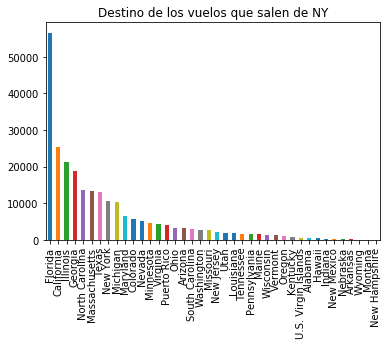

In [13]:
#Tabla de frecuencia de ciudades de destino.
mascara = dataset['ORIGIN_STATE_ABR']=='NY'
temp = dataset[mascara] #Filtro que permite centrarnos unicamente en los vuelos que salen de NY
a = pd.value_counts(temp['DEST_STATE_NM'])
b = 100 * temp['DEST_STATE_NM'].value_counts() / len(temp['DEST_STATE_NM'])
c = pd.concat([a, b], axis=1)
c.columns = ['Frecuencia' , 'Frecuencia Relativa (en %)']
print(c.head())
del a,b,c
temp['DEST_STATE_NM'].value_counts().plot(kind='bar',title='Destino de los vuelos que salen de NY')

In [14]:
# Tabla de contingencia Destino / Mes
pd.crosstab(index=temp['DEST_STATE_NM'],
            columns=temp['MONTH'], margins=True)

MONTH,1,2,3,4,5,6,7,8,9,10,11,12,All
DEST_STATE_NM,,,,,,,,,,,,,
Alabama,39,41,54,26,42,44,37,41,30,39,10,33,436
Arizona,252,244,303,292,271,262,266,259,225,247,230,249,3100
Arkansas,20,22,27,25,25,25,20,27,23,27,6,17,264
California,2081,1903,2227,2121,2141,2122,2203,2256,2033,2145,2035,2085,25352
Colorado,424,390,469,411,467,530,568,554,467,481,405,446,5612
Florida,4882,4530,5574,5274,4704,4464,4537,4511,3970,4297,4604,5248,56595
Georgia,1498,1368,1623,1576,1654,1604,1633,1667,1554,1637,1560,1538,18912
Hawaii,52,44,49,30,31,30,31,31,30,29,27,40,424
Illinois,1445,1366,1606,1517,1792,1974,2062,2130,1858,2007,1756,1716,21229


In [15]:
#Distribución de los vuelos con origen en NY durante el año.
temp2 = 100 * temp['MONTH'].value_counts() / len(temp['MONTH'])
temp2 = temp2.to_frame()
temp2.columns = ['Frecuencia relativa en (%)']
print(temp2)

    Frecuencia relativa en (%)
8                     8.923630
3                     8.841306
7                     8.701110
6                     8.574363
5                     8.574363
10                    8.496522
4                     8.303752
12                    8.187194
11                    8.048628
9                     7.998093
1                     7.967119
2                     7.383921


In [16]:
#Tabla de freciencia de vuelos cancelados
a = pd.value_counts(dataset['CANCELLED'])
b = 100 * dataset['CANCELLED'].value_counts() / len(dataset['CANCELLED'])
c = pd.concat([a, b], axis=1)
c.columns = ['Frecuencia' , 'Frecuencia Relativa (en %)']
c.index = ['No se cancelo',"Se canceló"]
print(c)
del a,b,c

               Frecuencia  Frecuencia Relativa (en %)
No se cancelo      467842                   97.449827
Se canceló          12243                    2.550173
